# Deep Belief Networks

In [198]:
import torch
import torch.nn as nn

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import matplotlib.pyplot as plt

import numpy as np

In [199]:
# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [200]:
# Define a single layer of the Deep Belief Network (as a Restricted Boltzmann Machine)
class RBM(nn.Module):
    def __init__(self, n_vis, n_hid):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hid, n_vis) * 0.1)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hid))

    def forward(self, v):
        # Forward pass - calculate the probabilities of hidden units given visible units
        p_h_given_v = torch.sigmoid(F.linear(v, self.W, self.h_bias))
        return p_h_given_v

In [201]:
class DBN(nn.Module):
    def __init__(self, n_vis, hidden_layers, n_out):
        super(DBN, self).__init__()
        self.rbms = nn.ModuleList(
            [
                RBM(
                    n_vis if i == 0 else hidden_layers[i-1],
                    h
                )
                for i, h in enumerate(hidden_layers)
            ]
        )
        self.output_layer = nn.Linear(hidden_layers[-1], n_out)

    def forward(self, v):
        for rbm in self.rbms:
            v = rbm(v)
        v = self.output_layer(v)
        return v  # No sigmoid for regression

In [202]:
# Load the dataset
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [203]:
dbn = DBN(n_vis=10, hidden_layers=[300, 200], n_out=1)

In [204]:
def train(dbn, train_loader, epochs, learning_rate, device):
    dbn.to(device)
    optimizer = torch.optim.Adam(dbn.parameters(), lr=learning_rate)
    loss_function = nn.MSELoss()  # Change to MSE Loss

    dbn.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            output = dbn(data)
            loss = loss_function(output, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 500 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss / len(train_loader)}')

In [205]:
train(dbn, train_loader, epochs=5500, learning_rate=0.0002, device=device)

Epoch 0, Loss: 29358.183268229168


Epoch 500, Loss: 9904.48046875
Epoch 1000, Loss: 4451.1069742838545
Epoch 1500, Loss: 3158.0037841796875
Epoch 2000, Loss: 2660.09521484375
Epoch 2500, Loss: 2500.7499389648438
Epoch 3000, Loss: 2281.1035970052085
Epoch 3500, Loss: 2008.4805297851562
Epoch 4000, Loss: 1793.4320475260417
Epoch 4500, Loss: 1646.388651529948
Epoch 5000, Loss: 1470.87744140625


In [206]:
def test(dbn, test_loader, device):
    dbn.eval()
    test_loss = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            output = dbn(data)
            test_loss += nn.MSELoss()(output, targets).item()

    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')

In [207]:
test(dbn, test_loader, device)

Test Loss: 2585.3934326171875


In [208]:
def get_predictions(model, data_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, targets in data_loader:
            data = data.to(device)
            output = model(data)
            actuals.extend(targets.numpy())
            predictions.extend(output.cpu().numpy())
    return np.array(actuals), np.array(predictions)

In [209]:
actuals, predictions = get_predictions(dbn, test_loader, device)

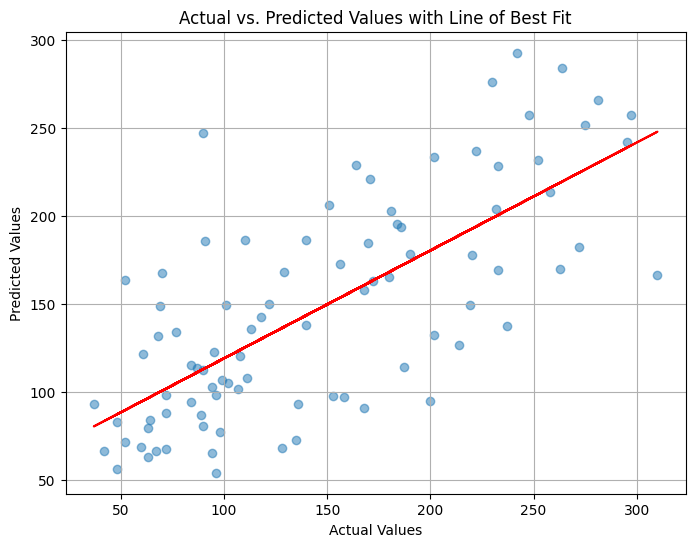

In [210]:
# Plotting a line of best fit
a, b = np.polyfit(actuals.flatten(), predictions.flatten(), 1)
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot(actuals, a*actuals + b, color='red')  # Line of best fit
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values with Line of Best Fit')
plt.grid(True)
plt.show()